# Computer Vision: Distillation

Previously we have built models from scratch as well as we have been using pre-build models. Many of these models are quite sophisticated performing complex tasks but they tend to be bulky models which makes them harder to deploy especially on mobile devices.

On obvious solution if to deploy our model on the cloud and forget about the issue. This solution has several drowbacks including the constant dependency on a quality internet connection.

The other approach would be to reduce the model size while mantaining the accuracy achieved in the more complex model. This is achieved by a couple of techniques:

1. **Knowledge Distillation**
2. **Model Compression**


## Knowledge Distillation

Is the process in which we train a small network with the help of the complex and bulky model. The objective is to have the small network to produce comparable results to the large model, which can be any state of the art models available or an ensemble model, and that is extracting very high level features from the data to produce accurate predictions.


### Teacher and Student methodology

We can look at this process from the point of view of a Teacher and Student methodology. We do not train the  distilled model (student) on the raw data but instead we train the student to mimic the output of the large network (teacher). This implies the usage of how the deeper network learns hierarchical abstractions of the features.

The transferring of the generalization ability to the small model can be done by the use of the class probabilities produced by the teacher model as “soft targets” for training the student model. During this transfer stage, we use the same training set or a separate “transfer” set as used for training the teacher model. When the teacher model is a large ensemble of simpler models, we can use arithmetic or geometric mean of their individual predictive distributions as the soft targets. When the soft targets have high entropy, they provide much more information per training case than hard targets and much less variance in the gradient between training cases, so the student model can often be trained on much less data than the original teacher model while using a much higher learning rate.

Much of the information about the learned function resides in the ratios of very small probabilities in the soft targets. This is valuable information that defines a rich similarity structure over the data (i. e. it tells as how much a car looks like a motorbike or a truck) but it has very little influence on the cross-entropy cost function during the transfer stage because the probabilities are so close to zero.

For distilling the learned knowledge we use Logits (the inputs to the final softmax). Logits can be used for learning the small model and this can be done by minimizing the squared difference between the logits produced by the teacher model and the logits produced by the student model.





Pruning reduces model size by removing weights or operations that are least useful for predictions (e.g.low-scoring weights). This can be very effective especially for on-device models involving sparse inputs or outputs, which can be reduced up to 2x in size while retaining 97% of the original prediction quality.
Quantization techniques are particularly effective when applied during training and can improve inference speed by reducing the number of bits used for model weights and activations. For example, using 8-bit fixed point representation instead of floats can speed up the model inference, reduce power and further reduce size by 4x.
Joint training and distillation approaches follow a teacher-student learning strategy — we use a larger teacher network (in this case, user-provided TensorFlow model) to train a compact student network (on-device model) with minimal loss in accuracy.

### References
- [1] [Learn2Compress](https://ai.googleblog.com/2018/05/custom-on-device-ml-models.html)
- [2] [Training compact Deep Learning models for video classification - Araujo](http://openaccess.thecvf.com/content_ECCVW_2018/papers/11132/Araujo_Training_compact_deep_learning_models_for_video_classification_using_circulant_ECCVW_2018_paper.pdf)

In [1]:
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,pandas,sklearn,tensorflow -g

import re
import os
import sys
from time import time
import pickle
import pathlib
import itertools
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import swifter
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import watermark

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

np.random.seed(42)

CPython 3.7.3
IPython 7.8.0

numpy 1.17.3
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.0.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.0.0
machine    : x86_64
processor  : i386
CPU cores  : 16
interpreter: 64bit
Git hash   : c6b9079d9be47f8dbb798dbc93d7f425d1c0a382


In [2]:
# Libraries specific of Deep learning and images
import imageio
from skimage.transform import resize as imresize
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf2
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input, Activation, Maximum, ZeroPadding2D, concatenate, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
sys.path.append(os.pardir)


1. **Introduction**
<br>

2. **Data preparation**
    - 2.1 Load data
    - 2.2 Check for null and missing values
    - 2.3 Normalization
    - 2.4 Reshape
    - 2.5 Label encoding


3. **CNN**
    - 3.1 Define the model
    - 3.2 Set the optimizer and annealer
    - 3.3 Data augmentation


4. **Model Evaluation**
    - 4.1 Training and validation curves


5. **Prediction**
    - 5.1 Predict samples
    - 5.2 Confusion matrix

## 1. Introduction

This is a 5 layers Sequential CNN build with **Keras API** and trained on MNIST dataset.

The model achieves a very high accuracy (99.52%) with this CNN trained in 1h25min on a laptop (MacBook Pro Intel Core i9). If you have a GPU at hand you can use tensorflow-gpu with keras. Computation will be much much faster!!!

Initially the number of epochs 3 but to achive the highest accurary you can set it to 30 epochs.

## 2. Data Preparation
### 2.1 Load data

The data is located at subfolders with the classes names in each parent folder.

In [4]:
PLANT_CLASSES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 
                 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 
                 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
CLASSES_DICT_NAMES = {name: k for k, name in zip(range(len(PLANT_CLASSES)), PLANT_CLASSES)}
CLASSES_DICT_NUM = {k: name for k, name in zip(range(len(PLANT_CLASSES)), PLANT_CLASSES)}
NUM_CATEGORIES = len(PLANT_CLASSES)

# INFO_DF = "./data/plants/info.gz"
# DATA_DF = "./data/plants/data.gz"
DF_PART1 = "./data/plants/plants_part1.gz"
DF_PART2 = "./data/plants/plants_part2.gz"
DF_PART3 = "./data/plants/plants_part3.gz"

DATA_FOLDER = "./data/plants"
RESHAPE_SIZE = (65, 65, 3)
RANDOM_STATE = 42

CLASSES_DICT_NAMES

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [5]:
# Build some abbreviations from the list
def get_abbreviation(name):
    split_regex = re.compile("[ \-,;:]")
    splitted = split_regex.split(name)
    if len(splitted) == 1:
        return splitted[0][:2].upper()
    else:
        return "".join([k[0].upper() for k in splitted])

ABBREVIATIONS = [get_abbreviation(m) for m in PLANT_CLASSES]
print(f"Abbreviations: {ABBREVIATIONS}")

Abbreviations: ['BG', 'CH', 'CL', 'CC', 'CW', 'FH', 'LSB', 'MA', 'SM', 'SP', 'SFC', 'SB']


In [6]:
df_p1 = pd.read_csv(DF_PART1)
df_p2 = pd.read_csv(DF_PART2)
df_p3 = pd.read_csv(DF_PART3)

df = pd.concat([df_p1, df_p2, df_p3], axis=0)
df.shape
df.columns[:10]

Index(['label', 'class', '0', '1', '2', '3', '4', '5', '6', '7'], dtype='object')

Count per category:
Loose Silky-bent             564
Common Chickweed             540
Scentless Mayweed            439
Small-flowered Cranesbill    431
Fat Hen                      422
Sugar beet                   355
Charlock                     347
Black-grass                  241
Cleavers                     224
Shepherd’s Purse             203
Maize                        197
Common wheat                 191
Name: class, dtype: int64


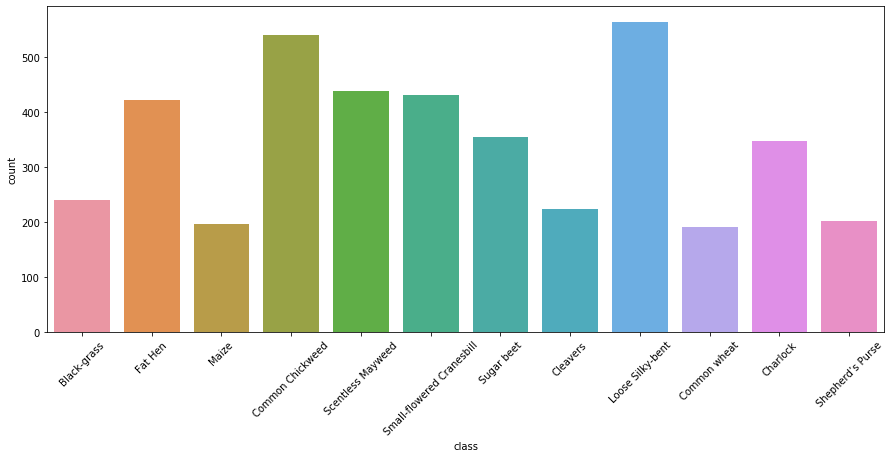

In [7]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation=45)
g = sns.countplot(df["class"])

print(f"Count per category:\n{df['class'].value_counts()}");

In [8]:
count_mean = df['class'].value_counts().mean()
upper_lvl = 100 * (df['class'].value_counts().max() - count_mean)/count_mean
lower_lvl = 100 * (df['class'].value_counts().min() - count_mean)/count_mean
print(f"Difference in the upper range: {upper_lvl:.1f}")
print(f"Difference in the lower range: {lower_lvl:.1f}")

Difference in the upper range: 62.9
Difference in the lower range: -44.8


Clearly we have an imbalance dataset. The difference in the counts across the different classes is quite high and the data needs to be balance in order to get the best results.

It's important to verify that we have a balanced distribution of cases across all the categories to avoid having a model with bias because of training in a few specific categories. If that happens the model will likely perform poorly in a generalized dataset that may not have the same bias.

Some techniques we may want to consider includes:
- Stratified sampling
- Cost-sensitive learning
- SMOTE and ROSE algorithms. SMOTE effectively uses a k-nearest neighbours approach to exclude members of the majority class while in a similar way creating synthetic examples of a minority class. ROSE tries to create estimates of the underlying distributions of the two classes using a smoothed bootstrap approach and sample them.

The following steps will consist on:
- Updating the class names to a numeric value
- Solve the unequal distribution of samples
- Create a train and test datasets

In [8]:
# Transform the class into a numeric value
df['class'] = df['class'].swifter.apply(lambda x: CLASSES_DICT_NAMES[x.replace("’", "")])

### 2.2 Check for null and missing values

In [9]:
# Check the data:
print(f"Any missing values in the dataset: {np.isnan(df['class']).any()}")

Any missing values in the dataset: False


In this case we don't have missing values, otherwise we may have to drop the entries that won't help to train our model.

### 2.3 Normalization

We normalize the data if required which helps to achieve a faster convergence. In this case it's already in the [0..1] range so theres is no need.

### 2.4 Reshape

Load images in the desired shape of 3D matrices.

In [10]:
# Extract the info (label and class) from the images data
df_info = df[["class"]]
df.drop(labels=["label", "class"], axis=1, inplace=True)

# Apply the shape required
df = df.values.reshape(-1, *RESHAPE_SIZE)

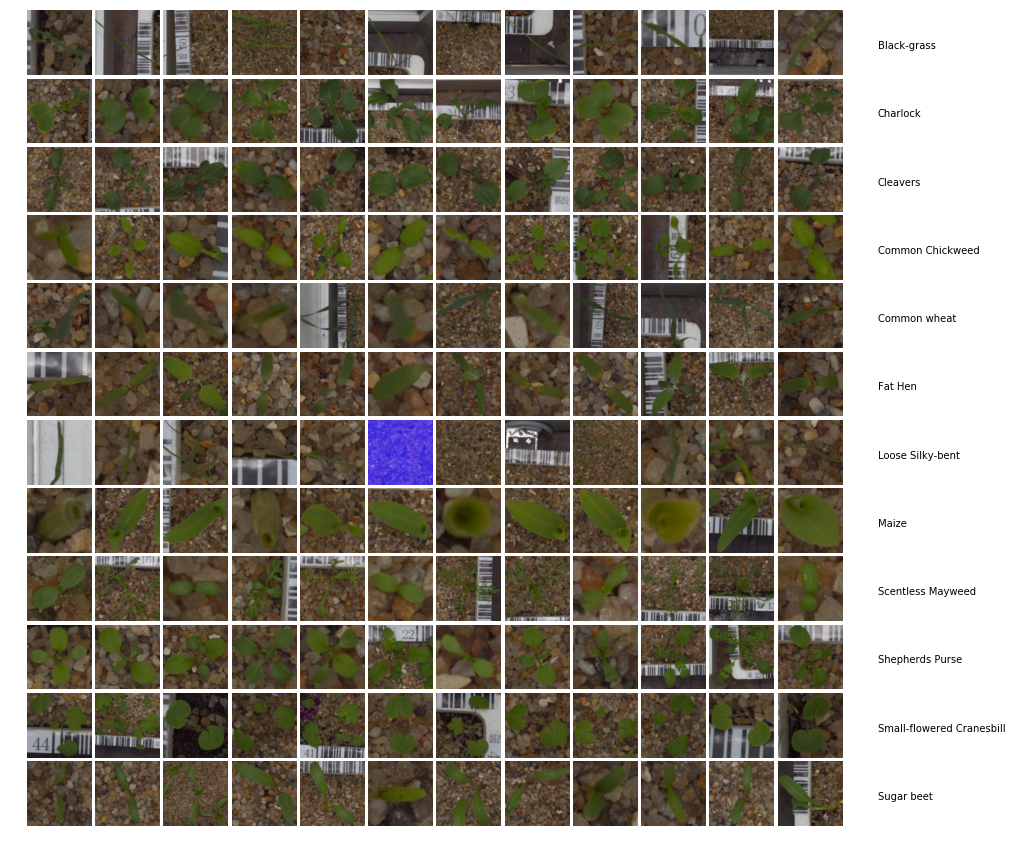

In [11]:
# Examples of the data
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category, category_id in CLASSES_DICT_NAMES.items():
    for img_data in df[df_info["class"]==category_id][:NUM_CATEGORIES]:
        ax = grid[i]
        ax.imshow(img_data)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(100, 35, category, verticalalignment='center')
        i += 1
fig.set_figheight(15)
fig.set_figwidth(15)
# plt.show();